In [1]:
import csv
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

from constants import *
from PIL import Image
from enum import Enum

# Embeds graphs in Jupyter notebook (instead of pop-ups)
%matplotlib inline

pd.set_option('display.max_columns', None) # show all columns
pd.set_option('display.max_rows', None) # show all rows

In [2]:
teams_df = pd.read_csv("./data/teams/teams.csv")
scores_df = pd.read_csv("./data/scores/scores.csv")
results_df = pd.read_csv("./data/scores/results.csv")
squad_value_df = pd.read_csv("./data/squad_values/squad_values.csv")

# Drop unwanted columns
teams_df = teams_df[list(sum(TEAM_COLUMNS_DICT_COMBINED.values(), []))]

# Merge with results dataframe
teams_df = pd.merge(
    results_df,
    teams_df,
    how='inner',
    left_on=['team_name', "season_start_year", "season_end_year"],
    right_on=['squad', "season_start_year", "season_end_year"]
).drop(["squad"], axis=1).rename(columns={"team_name": "squad"})

if "win_pct" not in TEAM_COLUMNS_DICT["squad"]["unaggregated"]:
    TEAM_COLUMNS_DICT["squad"]["unaggregated"].append("points")
if "win_pct" not in TEAM_COLUMNS_DICT_COMBINED["squad"]:
    TEAM_COLUMNS_DICT_COMBINED["squad"].append("points")

In [3]:
# Get per-game stats
# Note: meta fields like squad not inclued in unaggregated_cols
aggregated_cols = []
unaggregated_cols = [list(results_df.columns)[3:]]
for cat, val in TEAM_COLUMNS_DICT.items():
    unaggregated_cols += val["unaggregated"]
    new_cols = [f"{col}_per90" for col in val["unaggregated"]]
    teams_df[new_cols] = teams_df[val["unaggregated"]].div(teams_df['minutes_90s'], axis=0)
    val["aggregated"] += new_cols
    aggregated_cols += val["aggregated"]

TEAM_COLUMNS_DICT_COMBINED = dict((category, list(sum(vals.values(), []))) for category, vals in TEAM_COLUMNS_DICT.items())

In [4]:
teams_df.to_csv("./data/exploratory_analysis/main.csv", index=False)

In [5]:
def get_correlation(df, columns):
    '''Returns correlation between selected columns'''
    df_corr = df[columns].corr().abs() # get correlation matrix; absolute values for strength of correlation
    df_corr = df_corr.where(np.triu(np.ones(df_corr.shape)).astype(bool)) # get upper triangular values only
    df_corr = df_corr.stack().sort_values(ascending=False).reset_index()
    df_corr.columns = ['col_1', 'col_2', 'corr']
    return df_corr[df_corr['corr'] < 1].reset_index(drop=True)

def in_different_category(col1, col2):
    for col in TEAM_COLUMNS_DICT_COMBINED.values():
        if col1 in col and col2 in col:
            return False
    return True

In [6]:
# For getting icons when plotting graphs
class IconType(Enum):
    CLUB = "club_icons"
    COUNTRY = "country_icons"

#     "Cache" icons once processed
ICON_CACHE = { IconType.CLUB.name: {}, IconType.COUNTRY.name: {}, }
CLUB_ICON_MAPPING = dict(zip(SQUAD_NAME_MAPPING["final"], SQUAD_NAME_MAPPING["transfermarkt"]))
CLUB_ICON_MAPPING.update({"Empoli": "FC Empoli"})

def get_icon(type_: IconType, icon_name: str, scale: float = 0.1) -> Image:
    icon = ICON_CACHE[type_.name].get(icon_name)
    if icon:
        return icon
#     Find image
    img = Image.open(f"./data/{type_.value}/{icon_name}.png")
#     Resize
    ICON_CACHE[type_.name][icon_name] = img.resize((int(img.width*scale), int(img.height*scale)), Image.ANTIALIAS)
    return ICON_CACHE[type_.name][icon_name]

def get_country_icon(country_name: str, scale: float = 0.02) -> Image:
    return get_icon(type_=IconType.COUNTRY, icon_name=country_name, scale=scale)

def get_club_icon(squad_name: str, scale: float = 0.1) -> Image:
#     Note: need to map name in dataframe to saved name (as images taken from transfermarkt)
    return get_icon(type_=IconType.CLUB, icon_name=CLUB_ICON_MAPPING[squad_name], scale=scale)

### Win Determinants

Correlation with points per game (ppg)

In [7]:
teams_df.corr()["points_per90"].sort_values()

# Having to clear more often means opponents are creating more chances more often
# Indicative of back-foot play? Is high-pressing/high-possession the way to go?
# clearances_per90                        -0.642397
# tackles_def_3rd_per90                   -0.457455
# blocked_shots_per90                     -0.405874

# Importance of aerial duels
# aerials_lost_per90                      -0.526721

# More likely to lose if goalkeeper plays long?
# Need more data to check if goalkeeper plays long == don't build from the back == less-possession-based
# gk_pct_passes_launched                  -0.557303

# Easier to score from inside the box
# touches_att_pen_area_per90               0.774190
# passes_into_final_third_per90            0.780436

# More possession-heavy, dominant attacking sides win more points (as opposed to park and counter)
# touches_att_3rd_per90                    0.768357
# passes_total_distance_per90              0.753216
# touches_live_ball_per90                  0.757463
# possession                               0.748007

# Dribbling is important too
# carries_per90                            0.711977
# carries_into_penalty_area_per90          0.704944
# carries_progressive_distance_per90       0.698366

# Importance of set pieces
# corner_kicks_per90                       0.619333

# Creating chances > finishing chances
# shots_on_target_per90                    0.774389
# goals_per_shot_on_target                 0.527539

# Transition?
# progressive_passes_per90                 0.759548
# through_balls_per90                      0.562470

gk_goals_against_per90                  -0.745066
gk_goals_against                        -0.729361
goals_against                           -0.728838
gk_psxg                                 -0.684346
goals_against_away                      -0.670081
clearances_per90                        -0.642397
gk_shots_on_target_against_per90        -0.638135
gk_shots_on_target_against              -0.610437
clearances                              -0.598223
gk_pct_passes_launched                  -0.557303
goals_against_home                      -0.541499
aerials_lost_per90                      -0.526721
aerials_lost                            -0.518549
gk_goal_kick_length_avg                 -0.475750
passes_dead_per90                       -0.466674
tackles_def_3rd_per90                   -0.457455
tackles_def_3rd                         -0.420269
blocked_shots_per90                     -0.405874
blocked_shots                           -0.368806
average_shot_distance                   -0.367587


Which is more important in winning games: attack or defence?

In [8]:
# Comparing correlation: attack seems more strongly related
# goals_per90                              0.839428
# gk_goals_against_per90                  -0.745066

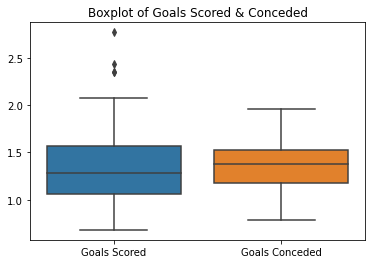


Outliers:


,index,squad,goals_per90,gk_goals_against_per90,country,gd_per90
0,32,Dortmund,2.3525,1.345588,GER,1.006912
1,77,PSG,2.3550,0.906433,FRA,1.448567
2,63,Manchester City,2.4350,0.828947,ENG,1.606053
3,15,Bayern Munich,2.7725,1.110294,GER,1.662206



Overview:


,goals_per90,gk_goals_against_per90,gd_per90
count,110.000000,110.000000,110.000000
mean,1.351288,1.363063,-0.011775
std,0.377594,0.255239,0.547132
min,0.680000,0.789474,-0.898421
25%,1.060625,1.174342,-0.391203
50%,1.285000,1.375000,-0.162895
75%,1.563125,1.524906,0.375965
max,2.772500,1.955882,1.662206



Interesting to note that while the mean is about the same, the spread of goals conceded is smaller than that of  goals scored. Does this mean scoring is what separates the better sides from the worse ones?


In [9]:
atk_vs_def_df = pd.merge(
    (
        teams_df[["squad", "goals_per90", "gk_goals_against_per90"]]
        .groupby("squad")
        .mean()
        .reset_index()
    ), teams_df[["squad", "country"]].copy(),
    how="left",
    on="squad",
).drop_duplicates().reset_index(drop=True)
atk_vs_def_df["gd_per90"] = atk_vs_def_df["goals_per90"] - atk_vs_def_df["gk_goals_against_per90"]

# Boxplot (melt to reshape dataframe and plot both variables on the same graph)
sns.boxplot(x="variable", y="value", data=pd.melt(
    atk_vs_def_df[["goals_per90", "gk_goals_against_per90"]].rename(columns={
        "goals_per90": "Goals Scored", "gk_goals_against_per90": "Goals Conceded",
    })
))

plt.xlabel('')
plt.ylabel('')
plt.title('Boxplot of Goals Scored & Conceded')
plt.show()

#     Calculate outliers
Q1 = atk_vs_def_df['goals_per90'].quantile(0.25)
Q3 = atk_vs_def_df['goals_per90'].quantile(0.75)
IQR = Q3 - Q1
atk_outliers_df = atk_vs_def_df[
    (atk_vs_def_df['goals_per90'] < Q1-1.5*IQR) |
    (atk_vs_def_df['goals_per90'] > Q3+1.5*IQR)
].sort_values(by='goals_per90').reset_index()
print("\nOutliers:")
display(atk_outliers_df)
print("\nOverview:")
display(atk_vs_def_df.describe())
print(
    "\nInteresting to note that while the mean is about the same, the spread of goals conceded is smaller than that of ",
    "goals scored. Does this mean scoring is what separates the better sides from the worse ones?"
)

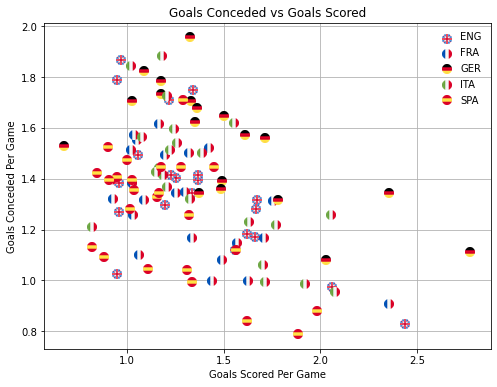

In [10]:
def plot_atk_def_graph():
    plt.xlabel('Goals Scored Per Game')
    plt.ylabel('Goals Conceded Per Game')
    plt.title('Goals Conceded vs Goals Scored')
    plt.grid(True)
    plt.show()

# Dictionary to map categories to images
images = {
    country: get_country_icon(country) for country in list(atk_vs_def_df["country"].sort_values().unique())
}

plt.figure(figsize=(8, 6))

for category, group in atk_vs_def_df.groupby('country'):
    plt.scatter(
        x=group['goals_per90'],
        y=group['gk_goals_against_per90'],
        label=category,
        s=0
    )

#     Set custom markers for country
    for x, y in zip(group['goals_per90'], group['gk_goals_against_per90']):
        imagebox = OffsetImage(images[category])
        plt.gca().add_artist(AnnotationBbox(imagebox, (x, y), frameon=False, pad=0))

plt.legend(framealpha=0, labelspacing=0.6)

# Add icons to each label in legend
for y, image in zip(np.arange(1.95, 1.6, -0.06), images.values()):
    imagebox = OffsetImage(image)
    plt.gca().add_artist(AnnotationBbox(imagebox, (2.65, y), frameon=False, pad=0))

plot_atk_def_graph()

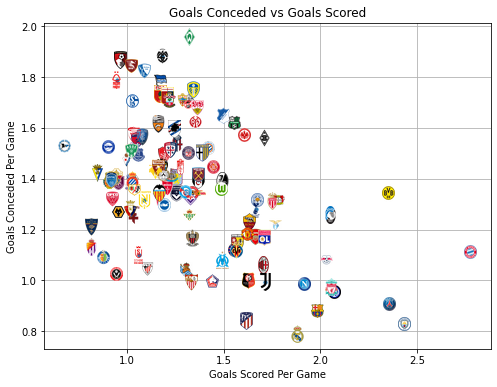

In [11]:
plt.figure(figsize=(8, 6))

plt.scatter(
    x=atk_vs_def_df['goals_per90'],
    y=atk_vs_def_df['gk_goals_against_per90'],
    label=category,
    s=10
)

#     Set custom markers for all clubs
for _, row in atk_vs_def_df.iterrows():
    imagebox = OffsetImage(get_club_icon(row["squad"]))
    plt.gca().add_artist(
        AnnotationBbox(imagebox, (row['goals_per90'], row['gk_goals_against_per90']),
        frameon=False, pad=0)
    )

plot_atk_def_graph()

,squad,goals_per90,gk_goals_against_per90,country,gd_per90
1,Bayern Munich,2.7725,1.110294,GER,1.662206
2,Manchester City,2.4350,0.828947,ENG,1.606053
3,PSG,2.3550,0.906433,FRA,1.448567
4,Dortmund,2.3525,1.345588,GER,1.006912
5,Inter,2.0725,0.953947,ITA,1.118553


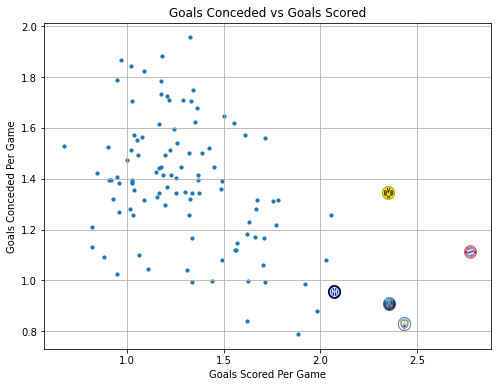

In [12]:
# Strongest attacking teams
top_5_atk_df = atk_vs_def_df.sort_values(by="goals_per90", ascending=False).head().reset_index(drop=True)
top_5_atk_df.index += 1
display(top_5_atk_df)

plt.figure(figsize=(8, 6))

plt.scatter(
    x=atk_vs_def_df['goals_per90'],
    y=atk_vs_def_df['gk_goals_against_per90'],
    label=category,
    s=10
)

#     Set custom markers for top 5 clubs
for _, row in top_5_atk_df.iterrows():
    imagebox = OffsetImage(get_club_icon(row["squad"]))
    plt.gca().add_artist(
        AnnotationBbox(imagebox, (row['goals_per90'], row['gk_goals_against_per90']),
        frameon=False, pad=0)
    )

plot_atk_def_graph()

,squad,goals_per90,gk_goals_against_per90,country,gd_per90
1,Real Madrid,1.8825,0.789474,SPA,1.093026
2,Manchester City,2.4350,0.828947,ENG,1.606053
3,Atl. Madrid,1.6200,0.842105,SPA,0.777895
4,Barcelona,1.9825,0.881579,SPA,1.100921
5,PSG,2.3550,0.906433,FRA,1.448567


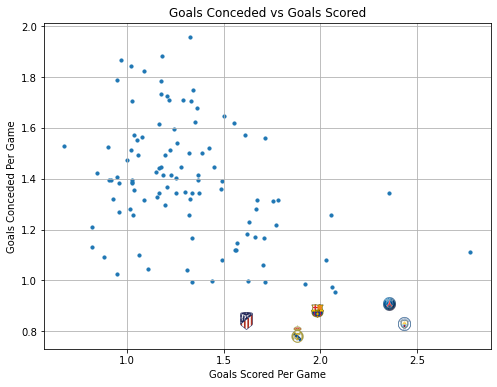

In [13]:
# Strongest defensive teams
top_5_def_df = atk_vs_def_df.sort_values(by="gk_goals_against_per90").head().reset_index(drop=True)
top_5_def_df.index += 1
display(top_5_def_df)

plt.figure(figsize=(8, 6))

plt.scatter(
    x=atk_vs_def_df['goals_per90'],
    y=atk_vs_def_df['gk_goals_against_per90'],
    label=category,
    s=10
)

#     Set custom markers for top 5 clubs
for _, row in top_5_def_df.iterrows():
    imagebox = OffsetImage(get_club_icon(row["squad"]))
    plt.gca().add_artist(
        AnnotationBbox(imagebox, (row['goals_per90'], row['gk_goals_against_per90']),
        frameon=False, pad=0)
    )

plot_atk_def_graph()

,squad,goals_per90,gk_goals_against_per90,country,gd_per90
1,Bayern Munich,2.7725,1.110294,GER,1.662206
2,Manchester City,2.4350,0.828947,ENG,1.606053
3,PSG,2.3550,0.906433,FRA,1.448567
4,Inter,2.0725,0.953947,ITA,1.118553
5,Barcelona,1.9825,0.881579,SPA,1.100921


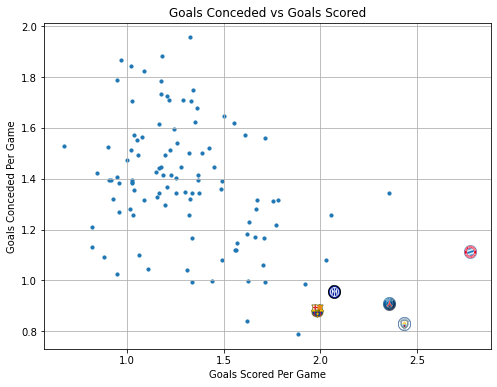

In [14]:
# Best goal difference
top_5_gd_df = atk_vs_def_df.sort_values(by="gd_per90", ascending=False).head().reset_index(drop=True)
top_5_gd_df.index += 1
display(top_5_gd_df)

plt.figure(figsize=(8, 6))

plt.scatter(
    x=atk_vs_def_df['goals_per90'],
    y=atk_vs_def_df['gk_goals_against_per90'],
    label=category,
    s=10
)

#     Set custom markers for top 5 clubs
for _, row in top_5_gd_df.iterrows():
    imagebox = OffsetImage(get_club_icon(row["squad"]))
    plt.gca().add_artist(
        AnnotationBbox(imagebox, (row['goals_per90'], row['gk_goals_against_per90']),
        frameon=False, pad=0)
    )

plot_atk_def_graph()

### Trends

Outliers

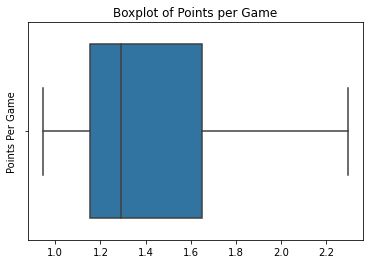


Overview:


,points_per90
count,110.000000
mean,1.401658
std,0.348071
min,0.947368
25%,1.151961
50%,1.289474
75%,1.651316
max,2.296053



No significant outliers. However, the average of the 99th percentile has a PPG 2.3 standard deviations larger than that of the median, indicating that there is a group of elite clubs.


In [15]:
ppg_mean_df = (
    teams_df.groupby(["squad"])[["squad", "points_per90"]]
    .mean()
    .sort_values(by="points_per90", ascending=False)
    .reset_index()
)

sns.boxplot(x=ppg_mean_df["points_per90"])

plt.xlabel('')
plt.ylabel('Points Per Game')
plt.title('Boxplot of Points per Game')
plt.show()

print("\nOverview:")
display(ppg_mean_df.describe())
upper_50_gap = round(
    ppg_mean_df[ppg_mean_df["points_per90"] >= ppg_mean_df['points_per90'].quantile(0.99)]["points_per90"].mean(), 2
)
print(f"\nNo significant outliers. However, the average of the 99th percentile has a PPG {upper_50_gap} standard deviations",
      "larger than that of the median, indicating that there is a group of elite clubs.")

Cross-category correlation

In [16]:
# Get correlation
teams_corr_df = get_correlation(teams_df, list(teams_df.columns))

# Filter out correlations between similar variables
teams_corr_df = teams_corr_df[
    teams_corr_df.apply(
        lambda row: in_different_category(row['col_1'], row['col_2']),
        axis=1
    )
].reset_index(drop=True)

In [17]:
# Note: the following correlation values are absolute (i.e. |corr|)
# as we are measuring strength of correlationship for now
# KIV: are a few outliers skewing the metrics?

# Strong correlation between passes and carries
# passes_live	carries_distance	0.889320
# passes_into_final_third	carries	0.883365
# passes_pct	carries	0.835825

# Strong correlation between progressive actions and: g/a, possession
# teams_corr_df[
#     (teams_corr_df['col_1'].str.contains("progressive", regex=True)) |
#     (teams_corr_df['col_2'].str.contains("progressive", regex=True))
# ]

# Strong correlation between possession and g/a
# teams_corr_df[
#     (
#         (teams_corr_df['col_1'].str.contains("possession", regex=True)) &
#         (teams_corr_df['col_2'].str.contains("x", regex=True))
#     ) | (
#         (teams_corr_df['col_1'].str.contains("x", regex=True)) &
#         (teams_corr_df['col_2'].str.contains("possession", regex=True))
#     )
# ]

# Looking at defensive metrics
# teams_corr_df[
#     (teams_corr_df['col_1'].isin(TEAM_COLUMNS_DICT_COMBINED["defence"])) |
#     (teams_corr_df['col_2'].isin(TEAM_COLUMNS_DICT_COMBINED["defence"]))
# ]

# High press =/= high possession
# teams_corr_df[
#     (teams_corr_df['col_1'].str.contains("tackles_att_3rd", regex=True)) |
#     (teams_corr_df['col_2'].str.contains("tackles_att_3rd", regex=True))
# ]

# Q: Is technical and physical ability mutually exclusive?
# A: Probably not? More direct/long-ball teams may lose more aerial duels and
# have lower overall pass accuracy (because of long balls)
# passes_pct	aerials_lost	0.756948
# passes_pct_short	aerials_won	0.625621